In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import phate
from scipy.interpolate import interp1d
import scipy.stats as stats
import mplcursors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian  # Assuming continuous outcome (e.g., suspense ratings)

from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

from scipy.interpolate import interp1d


## confirm number of subjects, neurons, trials

In [2]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'self'
# norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurons = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique()
print(f'{len(zero_FR_neurons)} neurons dropped because FR = 0 in encoding or baseline: {zero_FR_neurons}\n')

# drop these neurons
df_filtered = df[~df['neuron'].isin(zero_FR_neurons)]
df_encoding = df_filtered[df_filtered['stim_phase'] == 'encoding']
num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{len(df_encoding)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')

print(f'{len(scene_cells)} scene selective cells')

df_encoding.head()


df normalized by self

1457 total neurons

19 neurons dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10' 'P47CS_R1_19_4_1280_4' 'P47CS_R1_52_1_298_3'
 'P47CS_R2_22_1_8375_4' 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1'
 'P48CS_R2_58_3_6420_1' 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1'
 'P51CS_R2_48_4_5337_7' 'P53CS_R1_37_1_3731_5' 'P54CS_R1_70_2_5145_10'
 'P54CS_R2_31_1_2534_2' 'P55CS_R1_49_2_5469_3' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']

1438 neurons, 29 sessions, 16 subjects
1438 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

60 scene selective 

,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
0,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,0.0,478.85512,478.85512,"[3.43207675, 4.39507675, 5.16801325, 5.2624507...","[3.43207675, 4.39507675, 5.16801325, 5.2624507...",360,0.751793,"[-1.2730946020175409, -0.710811152793127, -0.1...",4.841224e-17,encoding,bd_movie,NaN,NaN,NaN
42,P41,P41CS_R1,P41CS_R1_38_1_613_5,ACC,0.0,478.85512,478.85512,"[0.2510465, 2.07970175, 4.70126325, 5.09220075...","[0.2510465, 2.07970175, 4.70126325, 5.09220075...",278,0.580551,"[0.1727115902171085, -0.4970723816004588, 0.17...",-5.958430e-17,encoding,bd_movie,NaN,NaN,NaN
84,P41,P41CS_R1,P41CS_R1_39_1_1359_5,ACC,0.0,478.85512,478.85512,"[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...","[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...",949,1.981810,"[-0.4841462836799911, -0.7340789431121942, -0....",9.682448e-17,encoding,bd_movie,NaN,NaN,NaN
126,P41,P41CS_R1,P41CS_R1_40_1_2816_5,ACC,0.0,478.85512,478.85512,"[0.0642965, 0.80051525, 0.813359, 0.89145275, ...","[0.0642965, 0.80051525, 0.813359, 0.89145275, ...",1820,3.800732,"[-1.277785091028816, -1.9862354843888455, -0.8...",9.682448e-17,encoding,bd_movie,NaN,NaN,NaN
168,P41,P41CS_R1,P41CS_R1_40_2_2821_5,ACC,0.0,478.85512,478.85512,"[0.4351715, 0.88882775, 1.79107775, 3.7156705,...","[0.4351715, 0.88882775, 1.79107775, 3.7156705,...",379,0.791471,"[0.3583427024917564, -0.2133277626874002, -0.7...",-4.841224e-17,encoding,bd_movie,NaN,NaN,NaN


## load suspense ratings, stretch it out to the entire time window, also obtain a differential of suspense

kernal thats being slid over: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


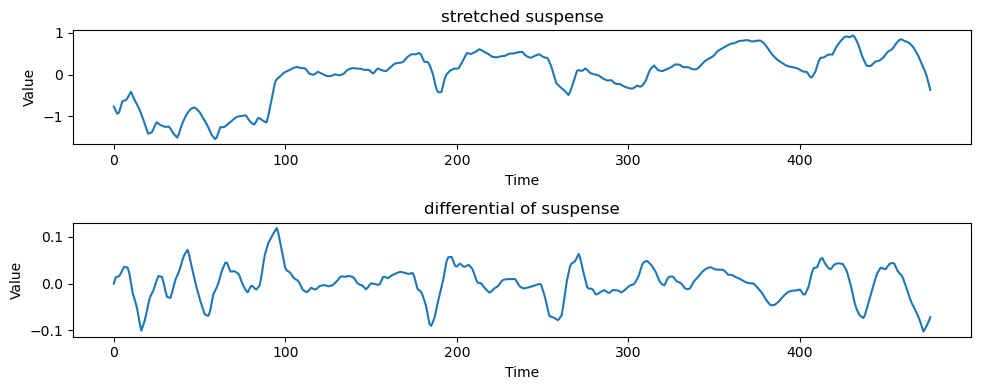

In [3]:
old_suspense = np.load('./data_files/avg_suspense.npy')

# 1. stretch suspense, via interpolation, to match the movie length
old_ts, expanded_ts = np.linspace(0, 1, len(old_suspense)), np.linspace(0, 1, len(df_encoding['trial_smooth_spikes'].iloc[0]))
suspense_interpolate_fn = interp1d(old_ts, old_suspense, kind='linear', fill_value="extrapolate")
stretched_suspense = suspense_interpolate_fn(expanded_ts)

# 2. obtain differential of suspense
diff_suspense = np.diff(stretched_suspense)
diff_suspense = np.insert(diff_suspense, 0, 0)
# smooth the differential using a moving average
diff_suspense = np.convolve(diff_suspense, np.ones(10) / 10, mode='same')
print(f'kernal thats being slid over: {np.ones(10) / 10}')

# plot
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

titles = ['stretched suspense', 'differential of suspense']
ts_data = [stretched_suspense, diff_suspense]

for ax, title, values in zip(axs.flat, titles, ts_data):
    ax.plot(values)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# # binarize suspense for classification
# sorted_indices = np.argsort(stretched_suspense)
# binary_suspense = np.zeros(len(stretched_suspense), dtype=int)
# binary_suspense[sorted_indices[len(stretched_suspense) // 2:]] = 1  # assign 1s to the larger half

# gun: 3:30 (210s), 4:27 (267), 6:00 (360),  7:00 (420), 7:30 (450)
peak_suspense_ts = [210,  267, 370, 430, 460]

## get scene cut info

In [4]:
# 1. all cuts
cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
cuts = cuts_df['shot_start_t'].tolist()
print(f'{len(cuts)} total cuts, at indices {cuts}')

# 2. scene cuts
scene_cut_inds = [0] # 1st frame is always a scene cut
scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)
scene_cuts = [cuts[i] for i in scene_cut_inds]
print(f'{len(scene_cuts)} scene cuts at t: {scene_cuts}')

# 3. color code all & scene cuts
cuts_df['cut_colors'] = 'grey'
cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
cuts_df.head(15)

93 total cuts, at indices [0.0, 4.72, 15.0, 16.72, 19.08, 21.72, 25.08, 27.08, 37.64, 46.16, 66.28, 66.8, 90.16, 92.72, 94.88, 99.32, 103.64, 108.28, 113.44, 115.0, 117.96, 120.0, 121.88, 126.52, 129.2, 137.56, 140.36, 143.36, 145.24, 147.88, 149.4, 150.76, 153.4, 153.92, 159.08, 161.16, 163.08, 167.28, 169.04, 170.68, 171.84, 173.48, 184.92, 211.6, 217.48, 254.24, 256.12, 261.6, 264.84, 266.68, 269.24, 273.04, 277.28, 281.28, 284.56, 288.76, 291.44, 307.88, 314.48, 328.52, 340.76, 346.2, 350.0, 357.84, 360.0, 362.56, 364.92, 367.76, 369.44, 371.64, 389.64, 407.88, 409.72, 419.04, 420.24, 424.36, 427.64, 428.72, 431.52, 433.48, 435.0, 437.52, 439.6, 442.28, 445.24, 450.04, 451.4, 453.04, 453.88, 456.44, 456.96, 459.32, 475.44]
13 scene cuts at t: [0.0, 27.08, 37.64, 46.16, 66.8, 184.92, 254.24, 314.48, 328.52, 340.76, 433.48, 435.0, 437.52]


,scene_id,shot_start_fr,shot_start_t,shot_dur_t,location,cut_type,cut_dur_t,cut_dur_fr,cut_colors
0,1.0,1.0,0.00,4.72,backyard,cut,0.00,0,red
1,1.0,119.0,4.72,10.28,backyard,cut,0.00,0,grey
2,1.0,376.0,15.00,1.72,backyard,cut,0.00,0,grey
3,1.0,419.0,16.72,2.36,backyard,cut,0.00,0,grey
4,1.0,478.0,19.08,2.64,backyard,cut,0.00,0,grey
5,1.0,544.0,21.72,3.36,backyard,cut,0.00,0,grey
6,1.0,628.0,25.08,2.00,backyard,cut,0.00,0,grey
7,2.0,678.0,27.08,10.56,livingroom,fadeout/fadein,0.40,10,red
8,3.0,942.0,37.64,8.52,bedroom,dissolve,0.48,12,red
9,4.0,1155.0,46.16,20.12,bedroom,cut,0.00,0,red


## setting up plotting vars

In [5]:
num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)
color_map = {'ACC': 'purple', 'amygdala': 'green', 'hippocampus': 'blue', 'preSMA': 'red', 'vmPFC': 'orange'}

## dropping neurons with >16s blocks of no spikes

In [6]:
neurs_to_drop = []
recording_block_sz = 16 # time chunks of recording neurons

# loop through each neuron row in df_encoding
for neur_idx, neur_row in df_encoding.iterrows():

    # get recording duration and spikes for the current neuron
    RT = int(neur_row['RT'])
    spike_train = np.array(neur_row['trial_aligned_spikes'])
    
    t1, toDrop = 0, False
    
    # go through trial to find empty blocks
    while t1 < RT - recording_block_sz:

        block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t1 + recording_block_sz)]
        t2 = t1

        if not np.any(block_spikes):
            
            toDrop = True

            # find next t where spikes occurs, as this will mark the end of the empty block
            for t2 in range(t1 + recording_block_sz, RT):
                
                bigger_block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t2)]
                if np.any(bigger_block_spikes):
                    break
                    
        if toDrop:
            neurs_to_drop.append(neur_idx)
            break

        t1 = t2+1

print(f'total neurons {len(df_encoding)}')
df_encoding = df_encoding.drop(neurs_to_drop).reset_index(drop=True)
print(f'retained neurons {len(df_encoding)}')
print(df_encoding.groupby('region').size())

total neurons 1438
retained neurons 1046
region
ACC            171
amygdala       329
hippocampus    193
preSMA         237
vmPFC          116
dtype: int64


## regressing suspense as a function of previous time points

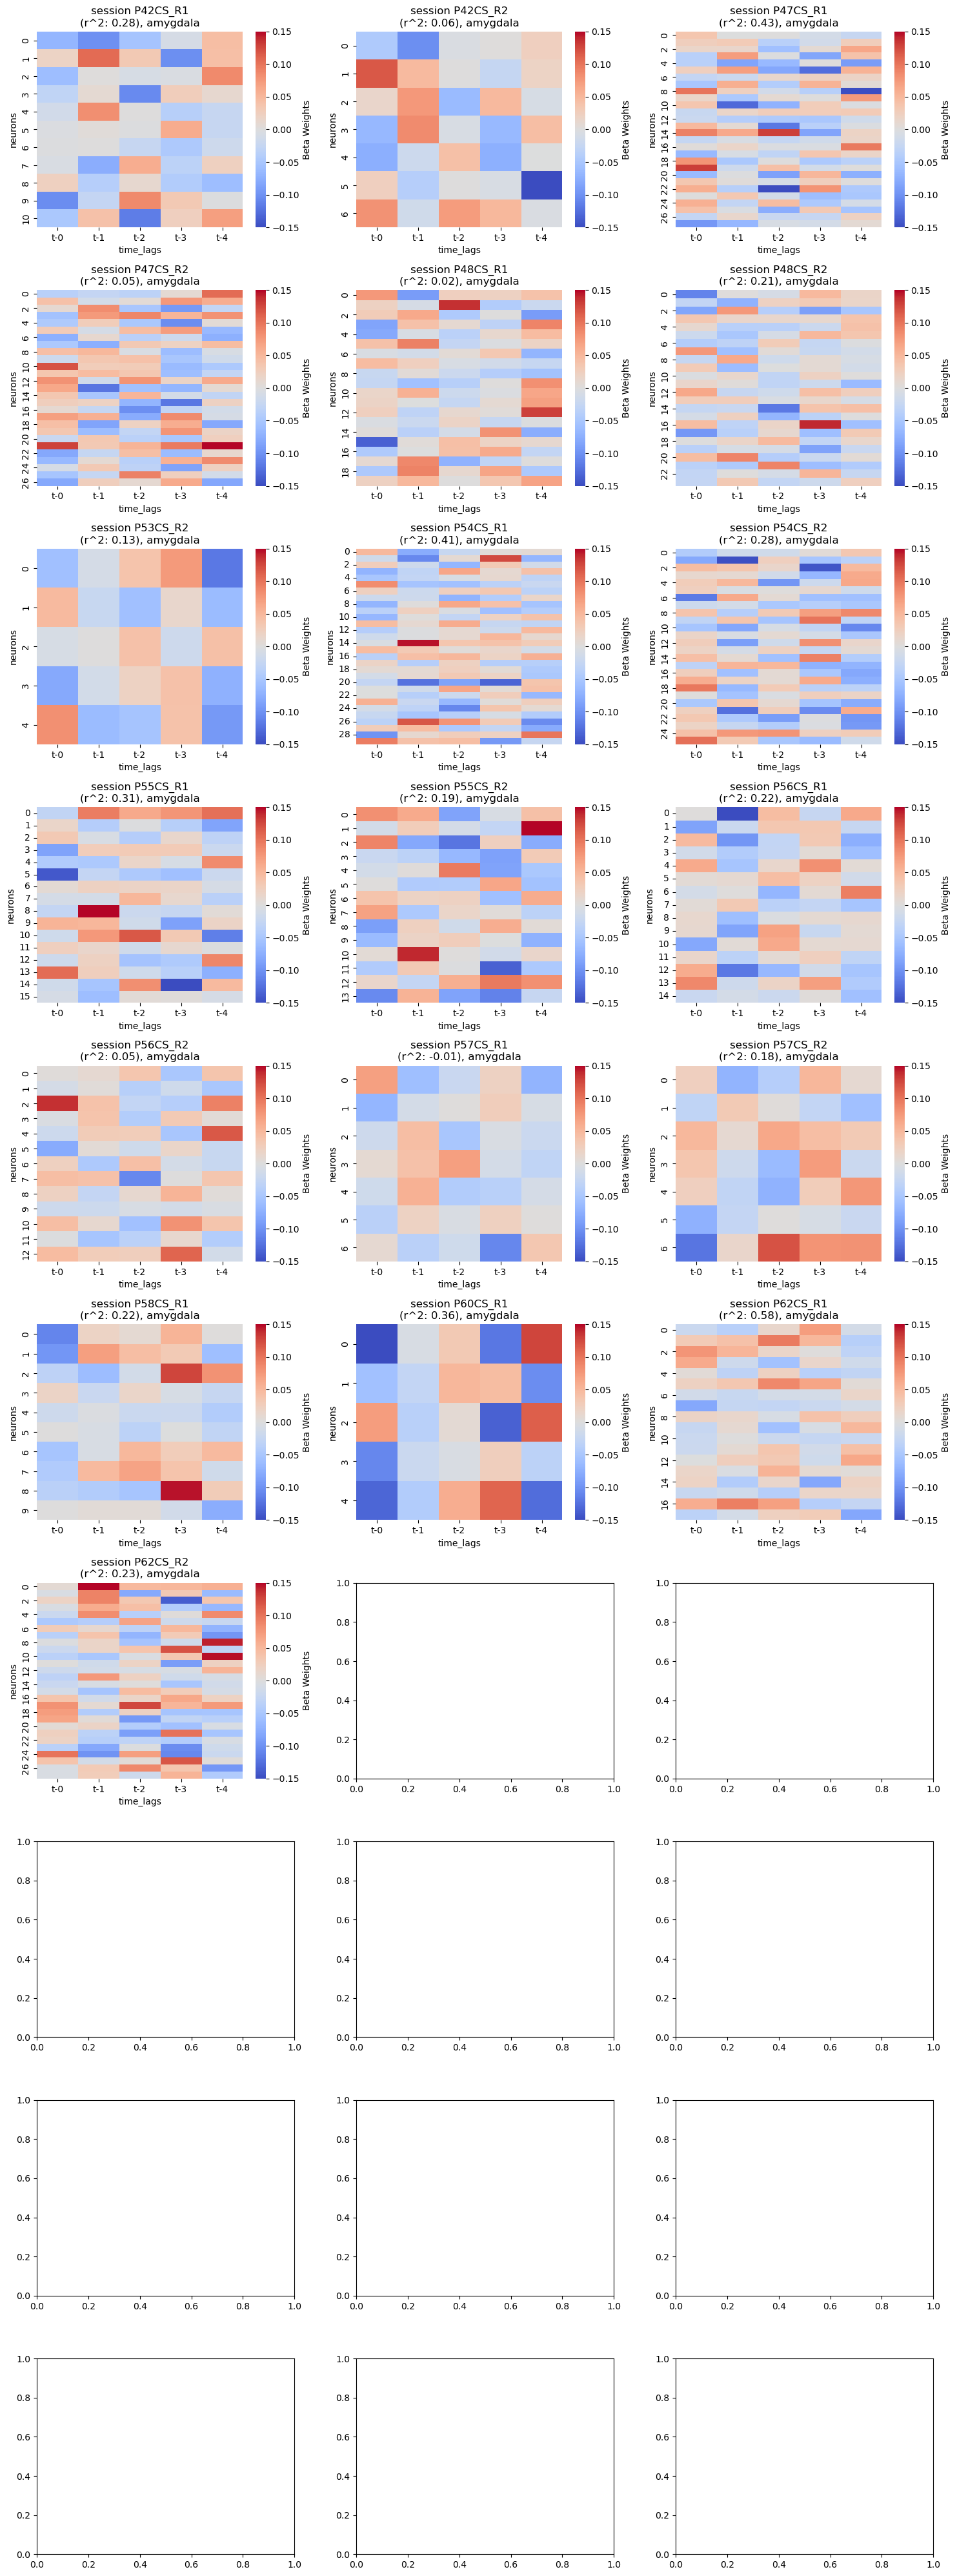

In [7]:
region = 'amygdala'
df_region = df_encoding[df_encoding['region'] == region]
sess_num, max_lag = 0, 5  # number of preceding time points

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(15, 4*10))
axs = axs.flatten()

for session, session_df in df_region.groupby('sess'):
    if len(session_df) < 5:  # less than 5 neurons
        continue

    # convert groupby obj to 2d array (neurons x time)
    subj, neur_by_time = session.split('CS')[0], np.array(session_df['trial_smooth_spikes'].tolist())

    ''' create lagged predictors, which eventually, after concatenation, has
        n_rows = n_features = n_neurons * n_lags, and
        n_cols = n_predictions = n_suspense_ts
    ''' 
    lagged_predictors = []

    # in each iteration, across all neuron rows, shift the spikes rightward (forward) in time
    for lag in range(max_lag):
        lagged_predictors.append(np.roll(neur_by_time, lag, axis=1))

    # concatenate lagged predictors vertically
    lagged_predictors = np.concatenate(lagged_predictors, axis=0)

    # drop first max_lag time points because they won't have enough predictors
    lagged_predictors, y = lagged_predictors[:, max_lag:], stretched_suspense[max_lag:]

    X_train, X_test, y_train, y_test = train_test_split(lagged_predictors.T, y, test_size=0.2, random_state=42) # split data

    # 1.
    glm = GLM(y_train, X_train, family=Gaussian())
    reg = glm.fit()
    weights = reg.params

    # 2.
    # reg = Ridge(alpha=0.1)
    # reg = Lasso(alpha=0.1)
    # reg.fit(X_train, y_train)
    # weights = reg.coef_

    y_pred = reg.predict(X_test)
    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

    # reshape beta weights for the current session as neuron * time
    weights_mtx = weights.reshape((neur_by_time.shape[0], max_lag))

    sns.heatmap(weights_mtx, cmap='coolwarm', cbar_kws={'label': 'Beta Weights'}, ax=axs[sess_num],
                vmax=.15, vmin=-0.15)
    axs[sess_num].set_xlabel('time_lags')
    axs[sess_num].set_xticklabels([f't-{i}' for i in range(max_lag)])
    axs[sess_num].set_ylabel('neurons')
    axs[sess_num].set_title(f'session {session}\n(r^2: {r2:.2f}), {region}')

    sess_num += 1
    # break

plt.tight_layout()
plt.show()


## plotting population autocorrelation (t:t+5) during peak suspense times (or scene cuts)

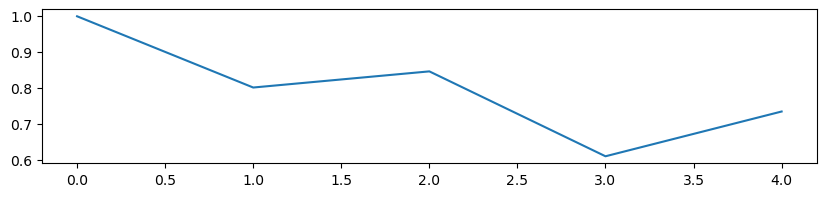

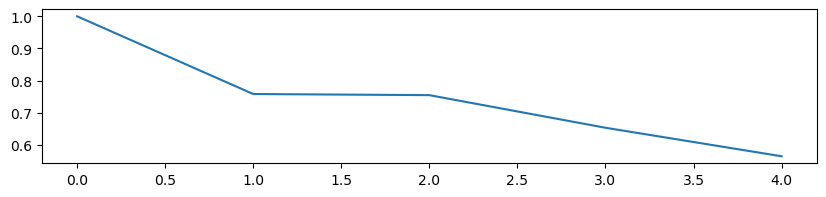

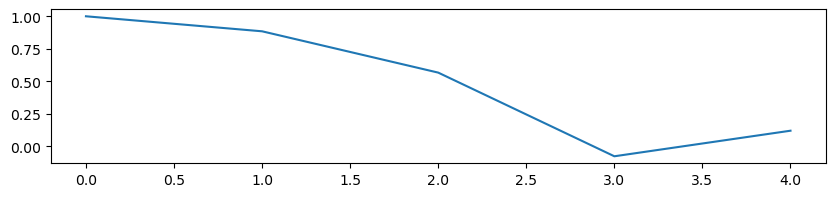

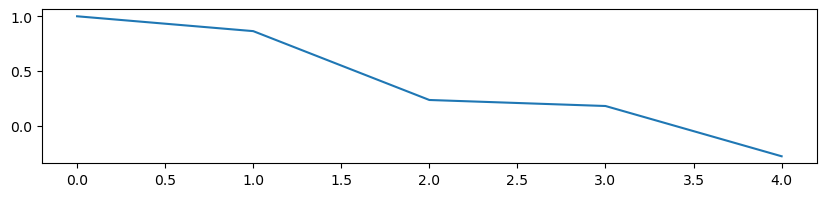

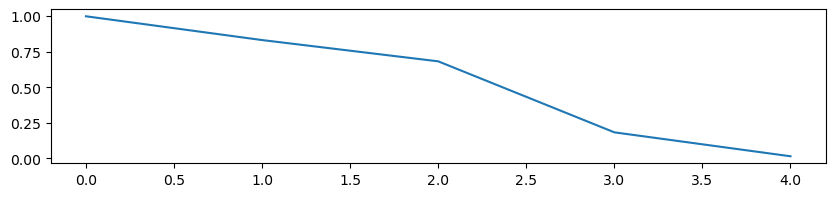

In [ ]:
region = 'amygdala'
df_region = df_encoding[df_encoding['region'] == region]
sess_num = 0

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:
        continue

    subj = session.split('CS')[0]

    # convert groupby obj to 2d arr
    neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())

    for peak_suspense_t in peak_suspense_ts:
    # for peak_suspense_t in cuts[:-1]:
        
        autocorr = []

        peak_suspense_t = int(peak_suspense_t)
        for t in range(5):
            autocorr.append(np.corrcoef(neur_by_time[:,peak_suspense_t].ravel(),
                                        neur_by_time[:, peak_suspense_t + t].ravel())[0,1])
        plt.figure(figsize=(10, 2))
        plt.plot(autocorr)
        plt.show()

    sess_num += 1
    break

## PCA as a function of suspense

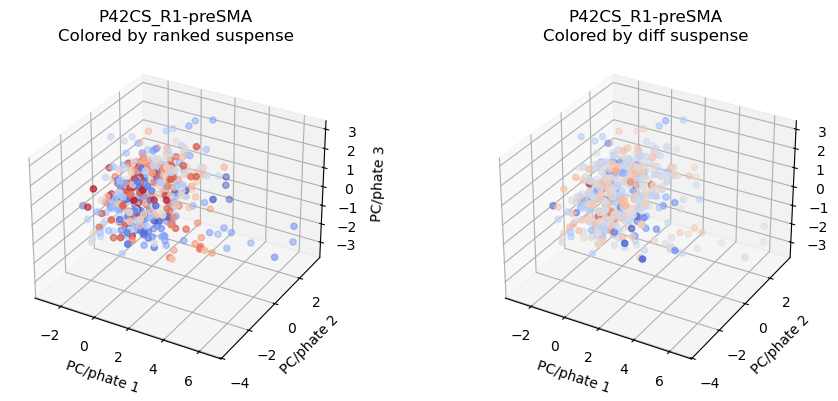

In [28]:
region = 'preSMA'
df_region = df_encoding[df_encoding['region'] == region]
sess_num = 0

suspense_ranked = stats.rankdata(stretched_suspense)
diff_suspense_ranked = stats.rankdata(diff_suspense)

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:
        continue

    subj = session.split('CS')[0]

    # convert groupby obj to 2d arr
    neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())

    # peform PCA
    pca = PCA(n_components=3)  # start with a few PCs
    pc_scores = pca.fit_transform(neur_by_time.T) # get time by neuron

    # # apply PHATE on PCA-reduced data
    # phate_operator = phate.PHATE(n_components=3, verbose=False)  # Set to 3 components for 3D
    # phate_embedding = phate_operator.fit_transform(pc_scores)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
    suspense_vars, suspense_titles = [suspense_ranked, diff_suspense], ['ranked suspense', 'diff suspense']

    for i in range(2):
        
        # could alternatively plot phate_embeddings
        scatter = axs[i].scatter(
            pc_scores[:, 0], pc_scores[:, 1], pc_scores[:, 2],
            c=suspense_vars[i], cmap="coolwarm"
        )
        axs[i].set_title(f"{session}-{region}\nColored by {suspense_titles[i]}")
        axs[i].set_xlabel("PC/phate 1")
        axs[i].set_ylabel("PC/phate 2")
        axs[i].set_zlabel("PC/phate 3")

        # plt.colorbar(scatter, ax=axs[ax_i], label=suspence_title, shrink=0.5)

    plt.tight_layout()
    plt.show()

    sess_num += 1
    
    break




## sliding window PCA to plot % explained by top PCs

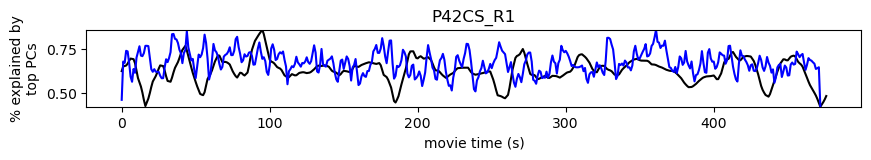

In [30]:
df_region = df_encoding[df_encoding['region'] == 'amygdala']
win_size = 5

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5: # only consider sessions with >5 neurons in region
        continue

    # convert groupby obj to 2d array
    neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())
    num_neurons, num_timepoints = neur_by_time.shape

    var_explained_by_top_PCs = []
    # slide window
    for start in range(0, num_timepoints - win_size + 1):

        window_data = neur_by_time[:, start:start + win_size]
        
        pca = PCA()
        pca.fit(window_data.T)
        
        # append % explained by top 2 PCs
        var_explained_by_top_PCs.append(np.sum(np.sort(pca.explained_variance_ratio_)[-1:]))

    var_explained_by_top_PCs = np.convolve(var_explained_by_top_PCs, np.ones(3)/3, mode='same')

    min_var, max_var = np.min(var_explained_by_top_PCs), np.max(var_explained_by_top_PCs)
    normed_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_var - min_var) + min_var
    normed_smooth_diff_suspense = (diff_suspense - np.min(diff_suspense)) / (np.max(diff_suspense) - np.min(diff_suspense)) * (max_var - min_var) + min_var

    plt.figure(figsize=(10, 1))
    plt.plot(normed_smooth_diff_suspense, label='suspense', color='black')

    timepoints = np.arange(0, num_timepoints - win_size + 1) 
    plt.plot(timepoints, var_explained_by_top_PCs, color='blue', label="Variance Explained by Top 3 Neurons")

    plt.xlabel('movie time (s)')
    plt.ylabel('% explained by\ntop PCs')
    plt.ylim(min_var, max_var)
    # plt.legend()
    plt.title(f'{session}')
    plt.show()

    break
